In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from imblearn.over_sampling import SMOTE


dfb = pd.read_csv('/content/BBASE.csv')

# conversion categoriale
dfb['email_is_free'] = dfb['email_is_free'].astype('category')
dfb['phone_home_valid'] = dfb['phone_home_valid'].astype('category')
dfb['phone_mobile_valid'] = dfb['phone_mobile_valid'].astype('category')
dfb['has_other_cards'] = dfb['has_other_cards'].astype('category')
dfb['foreign_request'] = dfb['foreign_request'].astype('category')
dfb['keep_alive_session'] = dfb['keep_alive_session'].astype('category')

# toutes les valeurs sont 0
dfb.drop(columns=['device_fraud_count'], inplace=True)


y = dfb['fraud_bool']
ds = dfb.drop(columns=['fraud_bool'])

# separation
categorical_columns = ds.select_dtypes(include=['object', 'category']).columns
numerical_columns = ds.select_dtypes(include=['number']).columns

# encoding
encoder = OneHotEncoder(sparse_output=False)
X_categorical_encoded = encoder.fit_transform(dfb[categorical_columns])

X_processed = np.hstack((X_categorical_encoded, ds[numerical_columns]))
X_processed = np.nan_to_num(X_processed, nan=-1)


X = np.array(X_processed)
y = np.array(y)

# equilibrage des données
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X = np.array(X_resampled)
y = np.array(y_resampled)

# Stratified train/test split
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_index, test_index = next(sss.split(X, y))

X_train, X_test = X[train_index], X[test_index]
y_train, y_test = y[train_index], y[test_index]

# Normalisation
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def create_model(activation='tanh', optimizer='adam', learning_rate=0.01, units=10):
    model = Sequential()
    model.add(Dense(units, activation=activation, input_dim=X_train_scaled.shape[1]))  # First hidden layer
    model.add(Dense(20, activation=activation))  # Second hidden layer (fixed for simplicity)
    model.add(Dense(1, activation='sigmoid'))  # Output layer (binary classification)

    # Instantiate the optimizer
    optimizers = {'adam': Adam}
    if optimizer not in optimizers:
        raise ValueError(f"Unsupported optimizer: {optimizer}")
    opt = optimizers[optimizer](learning_rate=learning_rate)

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model


model = KerasClassifier(build_fn=create_model, verbose=0)

# hyper_parametre tuning
param_grid = {
    'activation': ['relu', 'tanh'],
    'optimizer': ['adam'],
    'learning_rate': [0.001, 0.01],
    'batch_size': [32],
    'epochs': [10, 20],
    'units': [10, 20, 50]
}


grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1)


grid_result = grid.fit(X_train_scaled, y_train)


print(f"Best Parameters: {grid_result.best_params_}")
print(f"Best Score: {grid_result.best_score_:.2f}")

best_model = grid_result.best_estimator_
y_pred = (best_model.predict(X_test_scaled) > 0.5).astype(int)

Fitting 3 folds for each of 24 candidates, totalling 72 fits [Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers

Fit 1/24: Activation='relu', Batch Size=32, Epochs=10, Learning Rate=0.001, Optimizer='adam', Units=10
[CV 1/3] START model__activation=relu, model__optimizer=adam, model__units=10;
Epoch 1/10
32/32 - 0s - loss: 0.9494 - accuracy: 0.1435 - val_loss: 0.9684 - val_accuracy: 0.124 - 1.28ms/epoch
Epoch 2/10
32/32 - 0s - loss: 0.8923 - accuracy: 0.1833 - val_loss: 0.9099 - val_accuracy: 0.1685 - 0.96ms/epoch
Epoch 3/10
32/32 - 0s - loss: 0.8452 - accuracy: 0.2225 - val_loss: 0.8558 - val_accuracy: 0.2126 - 1.28ms/epoch
Epoch 4/10
32/32 - 0s - loss: 0.7902 - accuracy: 0.2564 - val_loss: 0.8045 - val_accuracy: 0.2386 - 0.96ms/epoch
Epoch 5/10
32/32 - 0s - loss: 0.7497 - accuracy: 0.2976 - val_loss: 0.7638 - val_accuracy: 0.2899 - 1.28ms/epoch
Epoch 6/10
32/32 - 0s - loss: 0.7012 - accuracy: 0.3428 - val_loss: 0.7167 - val_accuracy: 0.3344 - 1.28ms/epoch

In [ ]:
history_dict = history
history_dict.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

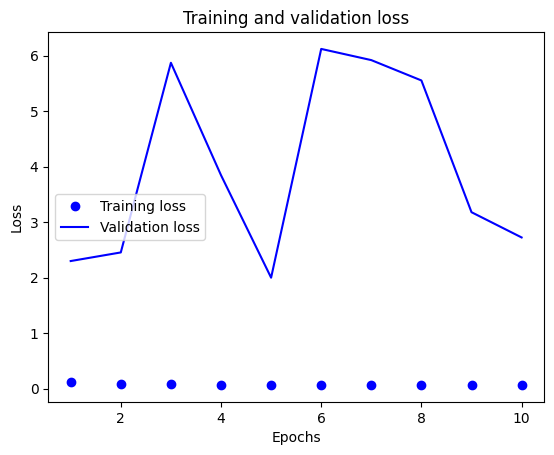

In [ ]:
import matplotlib.pyplot as plt

loss = history_dict.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')

plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

9233/9233 [==============================] - 10s 1ms/step


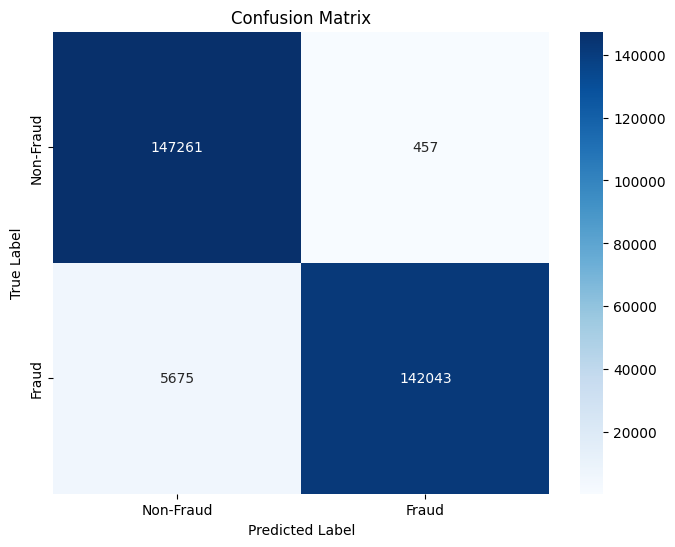

Accuracy: 0.98

Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98    147718
           1       1.00      0.96      0.98    147718

    accuracy                           0.98    295436
   macro avg       0.98      0.98      0.98    295436
weighted avg       0.98      0.98      0.98    295436



In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Évaluer le modèle sur le jeu de test
y_pred = (model.predict(X_test_scaled) > 0.5).astype(int)

# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Afficher la matrice de confusion
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Performance metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
